For a full explanation of the code, visit http://ataspinar.com/2017/12/04/using-convolutional-neural-networks-to-detect-features-in-sattelite-images/

In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt

#We are using owslib to download images from a WMS Service
#install with 'pip install owslib'

import owslib

from owslib.wms import WebMapService

#pyshp is necessary for loading and saving shapefiles
#install with 'pip install pyshp'
import shapefile

# Install opencv with 'pip install opencv-python'
import cv2

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
x_min = 90000
y_min = 427000
dx, dy = 200, 200
no_tiles_x = 100
no_tiles_y = 100
total_no_tiles = no_tiles_x * no_tiles_y

x_max = x_min + no_tiles_x * dx
y_max = y_min + no_tiles_y * dy
bounding_box = [x_min, y_min, x_max, y_max]

TILE_FOLDER = "./datasets/image_tiles_200/"
URL_TILES = "https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?request=GetCapabilities"

URL_SHP = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shp'
URL_PRF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.prj'
URL_DBF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.dbf'
URL_SHX = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shx'

URLS_SHAPEFILES = [URL_SHP, URL_PRF, URL_DBF, URL_SHX]

DATA_FOLDER = "./data/nwb_wegvakken/"

json_filename = DATA_FOLDER + '2017_09_wegvakken.json'

# 1. Downloading the image tiles

In [ ]:
#Skip if you already have the image tiles. Will take ~ 2hours.
wms = WebMapService(URL_TILES, version='1.1.1')

if not os.path.exists(TILE_FOLDER):
    os.makedirs(TILE_FOLDER)

for ii in range(0,25):
    print(ii)
    for jj in range(0,no_tiles_y):
        ll_x_ = x_min + ii*dx
        ll_y_ = y_min + jj*dy
        bbox = (ll_x_, ll_y_, ll_x_ + dx, ll_y_ + dy) 
        img = wms.getmap(layers=['Actueel_ortho25'], srs='EPSG:28992', bbox=bbox, size=(256, 256), format='image/jpeg', transparent=True)
        filename = "{}{}_{}_{}_{}.jpg".format(TILE_FOLDER, bbox[0], bbox[1], bbox[2], bbox[3])
        out = open(filename, 'wb')
        out.write(img.read())
        out.close()


## 1b. Downloading the shapefiles

In [ ]:
#Skip if you already have the shapefiles. Will take ~ 1hour.
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

for url in URLS_SHAPEFILES:
    filename = url.split('/')[-1]
    print("Downloading file {}".format(filename))
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(DATA_FOLDER + filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)     

# 2. Loading shapefile and converting to (GEO)Json

In [3]:
# Skip if conversion already done and "json_filename" already saved
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        serial = obj.isoformat()
        return serial
    if isinstance(obj, bytes):
        return {'__class__': 'bytes',
                '__value__': list(obj)}
    raise TypeError ("Type %s not serializable" % type(obj))

reader = shapefile.Reader(DATA_FOLDER + 'Wegvakken.shp')
fields = reader.fields[1:]
field_names = [field[0] for field in fields]

buffer = []
for sr in reader.shapeRecords()[:500000]:
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 


json_file = open(json_filename, "w")
json_file.write(json.dumps({"type": "FeatureCollection", "features": buffer}, indent=2, default=json_serial) + "\n")
json_file.close()

# 3. Declaring some variables and methods

In [3]:
dict_roadtype = {
    "G": 'Gemeente',
    "R": 'Rijk',
    "P": 'Provincie',
    "W": 'Waterschap',
    'T': 'Andere wegbeheerder',
    '' : 'leeg'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'leeg'
}

FEATURES_KEY = 'features'
PROPERTIES_KEY = 'properties'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'
WEGSOORT_KEY = 'WEGBEHSRT'

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 10 # Changed by David from 0.1

INPUT_FOLDER_TILES = './datasets/image_tiles_200/'

In [5]:
def add_to_dict(d1, d2, coordinates, rtype):
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)

def coord_is_in_bb(coord, bb):
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]



# 4. Map contents of shapefile to the tiles

In [6]:
filename_wegvakken = json_filename
dict_wegvakken = json.load(open(filename_wegvakken))[FEATURES_KEY]

In [7]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
    
for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, intermediate_coord, rtype)


# Added by David:
# 4a. Create dictionary of road-pixel matrices

In [8]:
# Initialize dictionary
d_road_pixels = {}

# Loop through all image tiles
for ii in range(0,no_tiles_x):
    for jj in range(0,no_tiles_y):
        ll_x = x_min + ii*dx
        ll_y = y_min + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile   
        # Extract list of road coordinates in tile
        tile_contents = d_tile_contents[tile]

        # Find pixel elements corresponding to roads
        # Fill in matrix of values
        pixel_mat = np.zeros((256,256))
        for elem in tile_contents:
            x = int(elem[1]*255)
            y = int((1-elem[2])*255)
            pixel_mat[y,x] = 1
        d_road_pixels[tile] = pixel_mat
        
        #plt.spy(pixel_mat)
        #plt.show()

# 4b. Visualize results

In [ ]:
x0 = 95000
y0 = 430000

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile        
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = plt.imread(filename).astype(int)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

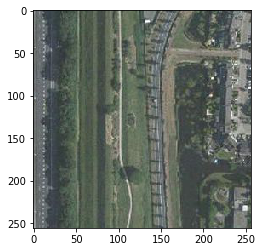

(256, 256, 3)
<class 'numpy.ndarray'>


In [9]:
# DK checks
image = "95000_430000_95200_430200.jpg"
filename = INPUT_FOLDER_TILES + image
image_view = plt.imread(filename).astype(int)
plt.imshow(image_view)
plt.show()
print(image_view.shape)
print(type(image_view))

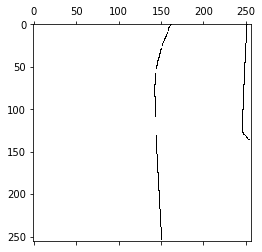

In [10]:
image = "95000_430000_95200_430200.jpg"
test_matrix = d_road_pixels[image]
plt.spy(test_matrix)
plt.show()

In [ ]:
x0 = 95400
y0 = 432000
POINTS_PER_METER = 0

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = plt.imread(filename).astype(int)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# 4c. Some statistics about the dataset

In [11]:
for rtype in d_roadtype_tiles.keys():
    roadtype = dict_roadtype[rtype]
    no_tiles = len(d_roadtype_tiles[rtype])
    print("Of roadtype {} ({}) there are {} tiles.".format(rtype, roadtype, no_tiles))

Of roadtype G (Gemeente) there are 4963 tiles.
Of roadtype W (Waterschap) there are 915 tiles.
Of roadtype P (Provincie) there are 48 tiles.
Of roadtype T (Andere wegbeheerder) there are 1 tiles.


# 5. Prepare dataset for CNN

In [12]:
def randomize(dataset, labels1, labels2):
    permutation = np.random.permutation(dataset.shape[0])
    print(permutation.shape)
    print(dataset.shape)
    print(labels1.shape)
    print(labels2.shape)
    randomized_dataset = dataset[permutation, :, :, :]
    randomized_labels1 = labels1[permutation, :]
    randomized_labels2 = labels2[permutation]
    return randomized_dataset, randomized_labels1, randomized_labels2

#  5a. Split each image into 16 tiles

In [13]:
def split_data(image, image_data, image_width, image_height, image_depth, split_factor):
    
    new_image_height = int(image_height/split_factor)
    new_image_width = int(image_width/split_factor)
    stride_x = new_image_width
    stride_y = new_image_height
    
    tiles_x = split_factor
    tiles_y = split_factor
    n_new_images = tiles_x*tiles_y

    # Initialize arrays for cropped images
    split_images = np.ndarray(shape=(n_new_images, new_image_width, \
                            new_image_height, image_depth), dtype=int)
    split_labels = np.ndarray(shape=(n_new_images, new_image_width, \
                            new_image_height), dtype=int)
    labels_roadpixel_img = d_road_pixels[image].astype(int)
    
    # Loop through matrices
    count = 0
    for i in range(tiles_x):
        for j in range(tiles_y):
            split_images[count] = image_data[(i*stride_x):((i+1)*stride_x), (j*stride_y):((j+1)*stride_y), :]
            split_labels[count] = labels_roadpixel_img[(i*stride_x):((i+1)*stride_x), (j*stride_y):((j+1)*stride_y)]
            count += 1

    # Check to make sure totals line up
    assert sum(split_images.flatten()) == sum(split_images.flatten())
    assert sum(labels_roadpixel_img.flatten()) == sum(split_labels.flatten())
    return split_images, split_labels
        
    

In [14]:
image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000
split_factor = 4

new_image_height = int(image_height/split_factor)
new_image_width = int(image_width/split_factor)
new_images = split_factor**2
new_total_images = new_images*total_no_images

image_files = os.listdir(INPUT_FOLDER_TILES)

# Initialize new datasets for cropped images
labels_filename = []
dataset = np.ndarray(shape=(new_total_images, new_image_width, \
                            new_image_height, image_depth), dtype=int)
labels_roadpixel = np.zeros((new_total_images, new_image_width * new_image_height))

# Loop through each image and add to dataset
for counter, image in enumerate(image_files):
    filename = INPUT_FOLDER_TILES + image
    image_data = plt.imread(filename).astype(int)
    split_images, split_labels_roadpixel = split_data(image, image_data, image_width, image_height, image_depth, split_factor)
    for i in range(new_images):
        labels_filename.append(image+"_"+str(i))           
        labels_roadpixel[counter*new_images + i] = split_labels_roadpixel[i].flatten()
        dataset[counter*new_images + i, :, :] = split_images[i]
    if counter % 1000 == 0:
        print("{} images have been loaded.".format(counter))
        
print(dataset.shape)
print(labels_roadpixel.shape)

0 images have been loaded.
1000 images have been loaded.
2000 images have been loaded.
3000 images have been loaded.
4000 images have been loaded.
5000 images have been loaded.
6000 images have been loaded.
7000 images have been loaded.
8000 images have been loaded.
9000 images have been loaded.
(160000, 64, 64, 3)
(160000, 4096)


In [15]:
labels_filename = np.array(labels_filename)
print("Randomizing dataset...")
dataset, labels_roadpixels, labels_filename = randomize(dataset, labels_roadpixel, labels_filename)

Randomizing dataset...
(160000,)
(160000, 64, 64, 3)
(160000, 4096)
(160000,)


In [23]:
# Split into train/validation/test sets
# For training set, subset on images with roads only
start_train_dataset = 0
start_valid_dataset = 150000
start_test_dataset = 155000
total_no_images = 160000

sum_labels = np.sum(labels_roadpixels[0:start_valid_dataset,:], axis=1)
idx_train = np.where(sum_labels > 0)[0]

output_pickle_file = './data/sattelite_dataset_pixel.pickle'

f = open(output_pickle_file, 'wb')
save = {
'train_dataset': dataset[idx_train,:,:,:],
'train_labels_roadpixels': labels_roadpixels[idx_train,:],
'train_labels_filename': labels_filename[idx_train],
'valid_dataset': dataset[start_valid_dataset:start_test_dataset,:,:,:],
'valid_labels_roadpixels': labels_roadpixels[start_valid_dataset:start_test_dataset,:],
'valid_labels_filename': labels_filename[start_valid_dataset:start_test_dataset],
'test_dataset': dataset[start_test_dataset:total_no_images,:,:,:],
'test_labels_roadpixels': labels_roadpixels[start_test_dataset:total_no_images,:],
'test_labels_filename': labels_filename[start_test_dataset:total_no_images]
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))


saved dataset to ./data/sattelite_dataset_pixel.pickle


# 6. The Convolutional neural network part (Using ResNet-50 for pixel level classification)

In [4]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [25]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [26]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s, s), padding = "valid", name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = "valid", name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = "valid", name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [27]:
def ResNet50(input_shape = (64, 64, 3)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = "avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(4096, activation='sigmoid', name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [28]:
# Define custom binary loss function with weights
def customLoss(pos_weight = 1):
    
    def weighted_binary_crossentropy( y_true, y_pred, weight = pos_weight) :
        y_true = K.clip(y_true, K.epsilon(), 1)
        y_pred = K.clip(y_pred, K.epsilon(), 1)
        logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
        
        return K.mean(logloss, axis=-1)
    
    return weighted_binary_crossentropy

In [29]:
model = ResNet50(input_shape = (64, 64, 3))
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy','sparse_categorical_accuracy'])

# Skip this section if using augmented dataset

In [5]:
pickle_file = './data/sattelite_dataset_pixel.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

train_dataset = save['train_dataset'].astype(dtype = int)
train_labels = save['train_labels_roadpixels'].astype(dtype = int)
valid_dataset = save['valid_dataset'].astype(dtype = int)
valid_labels = save['valid_labels_roadpixels'].astype(dtype = int)
test_dataset = save['test_dataset'].astype(dtype = int)
test_labels = save['test_labels_roadpixels'].astype(dtype = int)

f.close()

In [6]:
# Normalize image vectors
# For training set, subset on images with roads only
X_train = train_dataset/255.
X_valid = valid_dataset/255.
X_test = test_dataset/255.

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(train_labels.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(test_labels.shape))

number of training examples = 37366
number of test examples = 5000
X_train shape: (37366, 64, 64, 3)
Y_train shape: (37366, 4096)
X_test shape: (5000, 64, 64, 3)
Y_test shape: (5000, 4096)


In [7]:
# Augment labels to "pad" number of pixels classified as road
def pad_pixels(imgs,size,pixel_dist):
    new_imgs = np.zeros(imgs.shape)
    
    # Loop through each image in input
    for i in range(imgs.shape[0]):
        # Reshape image
        img = imgs[i,:].reshape(size,size)
        new_img = np.zeros(img.shape)
        # Loop through pixels and replace with 1 if any pixel is within range "pixel_dist"
        for x in range(size):
            for y in range(size):
                min_x = max(0, x - pixel_dist)
                max_x = min(size, x + pixel_dist)
                min_y = max(0, y - pixel_dist)
                max_y = min(size, y + pixel_dist)
                if img[min_x:max_x, min_y:max_y].max() == 1:
                    new_img[x,y] = 1
        new_imgs[i,:] = new_img.flatten()
    
    return new_imgs       
            

In [8]:
Y_train = pad_pixels(train_labels,size=64,pixel_dist=5)
Y_valid = pad_pixels(valid_labels,size=64,pixel_dist=5)
Y_test = pad_pixels(test_labels,size=64,pixel_dist=5)


In [21]:
Y_valid = pad_pixels(valid_labels,size=64,pixel_dist=5)

In [22]:
# Save augmented dataset
output_pickle_file = './data/sattelite_dataset_pixel_augm.pickle'

f = open(output_pickle_file, 'wb')
save = {
'train_dataset': X_train,
'train_labels_roadpixels': Y_train,
'valid_dataset': X_valid,
'valid_labels_roadpixels': Y_valid,
'test_dataset': X_test,
'test_labels_roadpixels': Y_test,
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))


saved dataset to ./data/sattelite_dataset_pixel_augm.pickle


# START HERE TO USE AUGMENTED DATASET

In [32]:
# Load augmented dataset
pickle_file = './data/sattelite_dataset_pixel_augm.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

X_train = save['train_dataset']
Y_train = save['train_labels_roadpixels'].astype(dtype = int)
X_valid = save['valid_dataset']
Y_valid = save['valid_labels_roadpixels'].astype(dtype = int)
X_test = save['test_dataset']
Y_test = save['test_labels_roadpixels'].astype(dtype = int)

f.close()

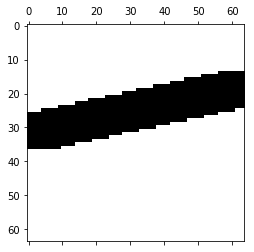

In [33]:
#plt.spy(train_labels[25,:].reshape(64,64))
#plt.show()
plt.spy(Y_train[25,:].reshape(64,64))
plt.show()

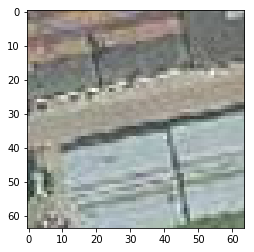

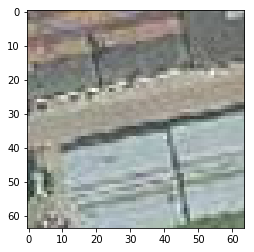

In [34]:
plt.imshow(train_dataset[25,:])
plt.show()
plt.imshow(X_train[25,:])
plt.show()

In [11]:
model_filepath = './data/resnet50_road_pixels.h5'
model = load_model(model_filepath)

In [12]:
tot_road_pixels = sum(Y_train[:,:].flatten())
tot_pixels = Y_train.shape[0] * Y_train.shape[1]
print(1 - tot_road_pixels/tot_pixels)

0.8252969778675802


In [49]:
# Train model--overfit to 10 examples
model.fit(X_train[20:30,:,:,:], Y_train[0:10,:], epochs = 10)

Epoch 1/10
10/10 [==============================] - 1s 122ms/step - loss: 4.9365e-04 - acc: 1.0000 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 122ms/step - loss: 4.8727e-04 - acc: 1.0000 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 122ms/step - loss: 4.8105e-04 - acc: 1.0000 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 122ms/step - loss: 4.7500e-04 - acc: 1.0000 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 122ms/step - loss: 4.6909e-04 - acc: 1.0000 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 123ms/step - loss: 4.6334e-04 - acc: 1.0000 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 122ms/step - loss: 4.5773e-04 - acc: 1.0000 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8/10
10

In [ ]:
# Train model
model.fit(X_train, Y_train, epochs = 1, batch_size = 512)

In [14]:
model.save(model_filepath)

In [ ]:
model.summary()

In [ ]:
# Evaluate model on dev set
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Image:


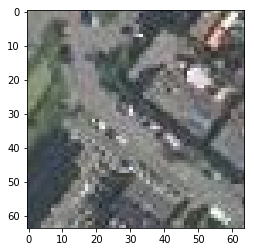

Ground truth labels:


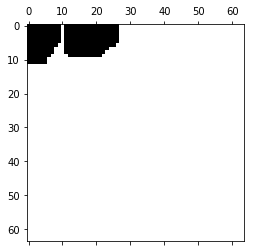

Predicted labels:
[[1.9107931e-05 2.6674026e-05 1.5966756e-05 ... 2.8078798e-03
  2.0642006e-03 1.6458844e-03]
 [1.1511842e-05 1.9037505e-05 1.5646860e-05 ... 3.8478372e-03
  2.2719339e-03 1.9294407e-03]
 [1.8812056e-05 9.2886057e-06 1.4139651e-05 ... 1.9751291e-03
  1.5029395e-03 1.7570650e-03]
 ...
 [2.9676133e-07 7.6763982e-08 1.5571911e-07 ... 2.0322503e-05
  1.2242264e-05 2.3726747e-05]
 [2.6821219e-08 3.6804796e-08 1.1356169e-08 ... 3.3087297e-05
  5.0148981e-05 1.9144833e-05]
 [1.8757936e-08 1.1749498e-07 5.2317398e-07 ... 1.3083572e-07
  1.9534694e-08 7.8200832e-09]]
[ 4 10 11 12 13 17 16 16 14 11  6  4  2  2  4  7  9  6  4  4  6  3  1  4
  3  4  2  2  2  1  1  2  0  0  0  2  1  0  3  8 10 14 15 15 14 15 14 15
 14 15 14 15 14 15 14 14  8 13 17 14 13 13 10  8]


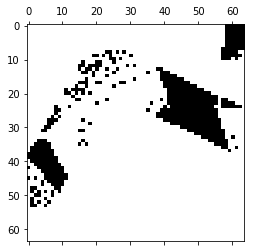

In [53]:
i = 23
image = X_train[i,:]
labels = Y_train[i,:]

print("Image:")
plt.imshow(image)
plt.show()

print("Ground truth labels:")
plt.spy(labels.reshape(64,64))
plt.show()

print("Predicted labels:")
img_for_pred = np.ndarray(shape=(1,64,64,3))
img_for_pred[0,:,:,:] = image
pred_probs = model.predict(img_for_pred).reshape(64,64)
print(pred_probs)
preds = np.where(pred_probs>0.001,1,0)
print(sum(preds))
plt.spy(preds)
plt.show()